In [11]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
from matplotlib.axes import Axes
from numpy.random import RandomState
from scipy import stats
from permute.core import one_sample
from utils import *
from typing import Dict
prng = RandomState(42)
sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1.5)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Load data
df = load_to_df('data/twitter_data.json')
df = df[df['shown_to_user']==True].reset_index(drop=True)
df.head()

100%|██████████| 1730/1730 [00:02<00:00, 831.70it/s] 


,timeline,rank,prob_in_tl,user_id,user_summary_leaning,collected_at,shown_to_user,user_race,user_ethnicity,user_gender,...,full_text_len,tweet_age,partisanship,outgroup_animosity,outgroup_animosity_to_ingroup,outgroup_animosity_to_outgroup,ingroup_affect,outgroup_affect,user_time_key,user_summary_race
0,Engagement,1.0,1.000,341,1,2023-02-11 17:05:08.233,True,[White],[None of these],Man,...,23,1064.087217,0.0,0,0,0,0.0,0.0,341_2023-02-11 17:05:08.233,White
1,Stated Preference,NaN,0.625,341,1,2023-02-11 17:05:08.233,True,[White],[None of these],Man,...,23,1064.087217,0.0,0,0,0,0.0,0.0,341_2023-02-11 17:05:08.233,White
2,Stated Preference with Downranking,NaN,0.625,341,1,2023-02-11 17:05:08.233,True,[White],[None of these],Man,...,23,1064.087217,0.0,0,0,0,0.0,0.0,341_2023-02-11 17:05:08.233,White
3,Engagement,2.0,1.000,341,1,2023-02-11 17:05:08.233,True,[White],[None of these],Man,...,136,501.270550,1.0,1,0,1,-1.0,-1.0,341_2023-02-11 17:05:08.233,White
4,Engagement,3.0,1.000,341,1,2023-02-11 17:05:08.233,True,[White],[None of these],Man,...,56,1195.270550,0.0,0,0,0,0.0,0.0,341_2023-02-11 17:05:08.233,White


# Binarized graphs

Globally define the columns that we will binarize over. `effect_cols` correspond to all reader and author emotions
and `effect_cols_binarized` will correspond to the binarized equivalent of each effect in `effect_cols`. This means that
if some effect takes on a non-zero value, we set it to 1, otherwise we leave it as 0.

In [13]:
effect_cols = ['author_angry', 'author_anxious', 'author_happy', 'author_sad', \
               'reader_angry', 'reader_anxious', 'reader_happy', 'reader_sad']
effect_cols_binarized = [f'{effect}_binarized' for effect in effect_cols]

In [14]:
def binarize_df(df: pd.DataFrame):
    """
    Returns a copy of the input `df` with the columns specified in `effect_cols` binarized. This means that
    if some effect takes on a non-zero value, we set it to 1, otherwise we leave it as 0.
    
    Params:
        df: DataFrame to add binarized emotion columns to.
    """
    
    binarized_df = df.copy()
    for effect in effect_cols:
        binarized_df[f'{effect}_binarized'] = binarized_df[effect].apply(lambda x: 1 if x > 0 else 0)

    return binarized_df

def generate_binarized_graph(mean_df: pd.DataFrame, mean_pol_df: pd.DataFrame):
    """
    Plots a 1x4 set of bar charts corresponding to author emotions, reader emotions, author emotions in 
    just political tweets, and reader emotions in just political tweets. In each subplot, there is a set 
    of four pairs of bars where each pair corresponds to an emotion (angry, anxious, happy, sad) and each
    bar in the pair corresponds to the Chronological or Engagement timeline. The y-axis of the bar chart 
    corresponds to the percent of the user timeline with the emotion.
    
    Params:
        mean_df: DataFrame with mean of all of the effects for all timelines
        mean_pol_df: DataFrame with mean of all of the effects for all timelines, filtered to just include 
            political tweets
    """
    
    mean_df_dict = {}

    unbinarized_emotions = ['angry', 'anxious', 'happy', 'sad']
    emotions = [f'{em}_binarized' for em in unbinarized_emotions]
    tl_types = ['Chronological', 'Engagement']

    charts = ['author emotions', 'reader emotions', 'author emotions (political)', 'reader emotions (political)']
    for chart in charts:
        mean_df_dict[chart] = {}
        ems = effect_cols_binarized[:4] if 'author' in chart else effect_cols_binarized[4:]
        subset_df = mean_pol_df if '(political)' in chart else mean_df

        for effect in ems: 
            mean_df_dict[chart][effect] = {}
            for tl in tl_types:
                mean_df_dict[chart][effect][tl] = subset_df[effect][tl]

    bar_width = 0.35
    index = np.arange(len(emotions))
    double_bar_positions = [i - bar_width/2 for i in index] + [i + bar_width/2 for i in index]

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    global_max = max([value[tl] for title, emotions in mean_df_dict.items() \
                      for emotion, value in emotions.items() for tl in tl_types])

    for i, (title, emotion_data) in enumerate(mean_df_dict.items()):
        chron_vals = [emotion_data[f'{title.split()[0].lower()}_{emotion}']['Chronological'] for emotion in emotions]
        eng_vals = [emotion_data[f'{title.split()[0].lower()}_{emotion}']['Engagement'] for emotion in emotions]

        chron_bars = axes[i].bar(double_bar_positions[:4], chron_vals, bar_width, label='Chronological', \
                                 color=sns.color_palette()[7])
        eng_bars = axes[i].bar(double_bar_positions[4:], eng_vals, bar_width, label='Engagement', \
                               color=sns.color_palette()[0])

        axes[i].set_title(title.title())
        axes[i].set_xticks(index)
        axes[i].set_xticklabels([em.title() for em in unbinarized_emotions])
        axes[i].xaxis.grid(False)

        axes[i].set_ylim(0, global_max + 0.1 * global_max)

        # Hide redundant y-tick labels
        if i > 0:
            axes[i].set_yticklabels([])
            
    # Set shared x and y labels
    axes[0].set_ylabel('% of User Timeline with Emotion', labelpad=15, weight='bold')
    
    fig.legend([chron_bars, eng_bars], tl_types, loc=(0.865, 0.8))
    
    plt.tight_layout()
    plt.savefig("figures/likert/binarized_ems.pdf", format="pdf")
    
    plt.show()

In [15]:
binarized_df = binarize_df(df)

In [16]:
mean_df = get_mean_by_tl(binarized_df, effect_cols_binarized) * 100

/Users/smitha/research/twitter-analysis/utils.py:426: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(["user_time_key", "timeline"])[keys].agg(**aggregations)
/Users/smitha/research/twitter-analysis/utils.py:437: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return grouped.groupby(["user_id", "timeline"]).mean()
/Users/smitha/research/twitter-analysis/utils.py:446: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this wa

In [17]:
mean_df

,author_angry_binarized,author_anxious_binarized,author_happy_binarized,author_sad_binarized,reader_angry_binarized,reader_anxious_binarized,reader_happy_binarized,reader_sad_binarized
timeline,,,,,,,,
Chronological,18.395881,23.185795,52.447885,17.020398,15.243165,20.225204,43.973321,17.414367
Engagement,25.962772,27.897330,52.686505,20.785668,19.540493,22.272462,45.642182,19.119108
Stated Preference,19.817843,24.601180,56.750811,18.076401,16.376972,21.692147,54.951864,18.254552
Stated Preference with Downranking,17.227254,23.440309,58.167144,16.668223,14.314224,20.640312,56.382798,17.019362


In [18]:
pol_df = df[df['is_political']]
mean_pol_df = get_mean_by_tl(binarize_df(pol_df),  effect_cols_binarized) * 100

/Users/smitha/research/twitter-analysis/utils.py:426: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(["user_time_key", "timeline"])[keys].agg(**aggregations)
/Users/smitha/research/twitter-analysis/utils.py:437: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  return grouped.groupby(["user_id", "timeline"]).mean()
/Users/smitha/research/twitter-analysis/utils.py:446: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this wa

In [19]:
mean_pol_df

,author_angry_binarized,author_anxious_binarized,author_happy_binarized,author_sad_binarized,reader_angry_binarized,reader_anxious_binarized,reader_happy_binarized,reader_sad_binarized
timeline,,,,,,,,
Chronological,52.151140,43.752073,24.341245,38.280690,46.892884,45.728624,21.663305,42.065015
Engagement,62.312327,46.123456,23.943917,41.538188,51.278580,42.928951,20.535568,41.383451
Stated Preference,54.308634,43.412806,27.291987,39.791724,48.723039,44.877334,26.938038,42.338558
Stated Preference with Downranking,45.330109,40.905999,29.562576,36.030772,43.613100,43.260787,29.662800,40.423051


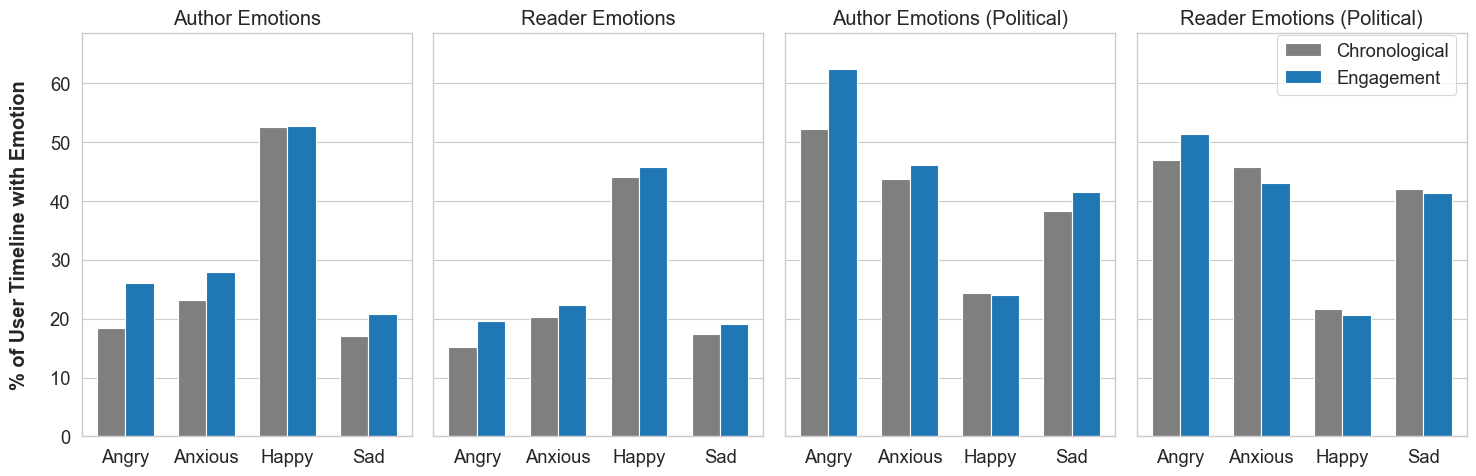

In [20]:
generate_binarized_graph(mean_df, mean_pol_df)

# Likert question distributions

For each effect (corresponding to column `key`), plot respondents' distributions on the scale of likert values it can take on (ex: 1 to 5 or -2 to 2 based on the question). Each row corresponds to the timeline type (Chronological or Engagement).

In [21]:
def get_pcts_df(df: pd.DataFrame, effect: str, scale: list[int]):
    """
    Params:
        df: DataFrame containing data of user survey responses, may be for all tweets or filtered down to political
        effect: key to generate response distribution for
        scale: range of values that the `effect` key can take on
        
    Returns:
        DataFrame with response distribution for the given `effect` in percentages
    """
    
    chron_df = get_resp_dist_for_tl(df, effect, Timeline.CHRONOLOGICAL, scale)
    eng_df = get_resp_dist_for_tl(df, effect, Timeline.ENGAGEMENT, scale)
    combined_df = pd.merge(chron_df, eng_df, on='likert_score', suffixes=('_chron', '_eng'))
    return combined_df

def create_likert_effects_subplot(df: pd.DataFrame, 
                                  effects: list[str], 
                                  ax: Axes, 
                                  title: str, 
                                  likert_text: Dict[int, str], 
                                  table_titles: list[str],
                                  should_plot_effect: bool = False, 
                                  should_plot_tl: bool = False):
    """
    Plots a stacked bar chart horizontally with each effect in `effects` corresponding to one pair of stacked bars.
    In each pair of stacked bars, one bar corresponds to data from the Chronological timeline and the other corresponds
    to the Engagement timeline.
    
    Additionally prints out tables with likert scores and text and response distribution for chronological and engagement 
    timelines.
    
    Params:
        df: DataFrame containing data of user survey responses, may be for all tweets or filtered down to political
        effects: keys in `df` to plot in chart
        ax: axes to plot over, provided by calling function
        title: title of bar chart plot
        likert_text: dictionary where keys corresponding to the likert score that the user responded with and the value
            corresponding to the text displayed for the question corresponding to effects
        table_titles: list of strings corresponding to titles for individual tables corresponding to plotted effects
        should_plot_effect: boolean value specifying whether to plot the effects on the left y-axis
        should_plot_tl: boolean value specifying whether to plot C vs. E corresponding to timeline type on the right y-axis        
    """
    
    bar_height = 0.35
    
    # scale are the scores in the likert_text dictionary
    scale = list(likert_text.keys())
    
    # allow effects to be empty
    dfs = [get_pcts_df(df, effect, scale) for effect in effects] if effects else df

    # position of the bars on the y-axis
    indices = range(len(dfs))

    for idx, df in enumerate(dfs):
        # create stacked bars
        left_chron = 0
        left_eng = 0

        for _, row in df.iterrows():
            score = int(row['likert_score'])
            color = sns.color_palette()[score]

            ax.barh(idx, row['percent_eng'], bar_height, left=left_eng, color=color, label=score)
            ax.barh(idx + bar_height, row['percent_chron'], bar_height, left=left_chron, color=color, label=score)

            left_chron += row['percent_chron']
            left_eng += row['percent_eng']

    ax.set_title(title, weight='bold', fontsize=20)
    ax.margins(x=0)
    ax.xaxis.grid(True)

    # display y-axis ticks and labels based on where the subplot is located        
    ax.set_yticks([i + bar_height/2 for i in indices])

    # left axis y-labels
    if should_plot_effect:
        ax.set_yticklabels([i.split('_')[1].capitalize() if '_' in i else i for i in effects])
    else:
        ax.set_yticklabels([]) 
        ax.set_yticks([])

    # right axis y-labels
    if should_plot_tl:
        ax2 = ax.twinx()

        yticks = []
        
        if len(effects) > 1:
            # if effects are specified, we have several stacked bar plots and need to create
            # custom coordinates.
            space_btwn_pairs = 0.24
            bar_offset = 0.09

            for i in indices:
                bottom_label_coord = i * space_btwn_pairs + bar_offset
                space_btwn_bars = bar_height * 0.25

                yticks.append(bottom_label_coord)
                yticks.append(bottom_label_coord + space_btwn_bars)
                
            ax2.set_yticks(yticks)
                
            # format labels on right y axis
            ax2.set_yticklabels(['E' if i % 2 == 0 else 'C' for i in range(2 * len(effects))])
        else:
            offset = 0.65 * bar_height
            ax2.set_yticks([0.5 - offset, 0.5 + offset])
            ax2.set_yticklabels(['E', 'C'])

        # hides tick marks, adds padding
        ax2.tick_params(axis='y', which='major', length=0, pad=10) 
        for label in ax2.get_yticklabels():
            label.set_ha('center')

        ax2.yaxis.grid(False)
        
    # print out dfs for individual bars
#     for df, title in zip(dfs, table_titles):
#         df['likert_text'] = likert_text.values()
#         df = df.reindex(columns=['likert_score', 'likert_text', 'percent_chron', 'percent_eng'])
#         print(title)
#         display(df)
        
def offset_palette(offset: int, num_colors: int = 5):
    """
    Offsets Seaborn viridis color palette for the caller plotting function. Used for plotting functions where the
    starting value in the data may be negative (for cases where we directly index into the color palette, ex: palette[x]).
    
    Params:
        offset: integer value that offsets seaborn color palette
        num_colors: number of colors that palette takes on in the caller plotting function    
    """
    
    colors = sns.color_palette("viridis", num_colors)
    offset_colors = colors[offset:] + colors[:offset]
    sns.set_palette(offset_colors)

def generate_titles_for_effects(effect: str, is_political: bool = False):
    """
    Generates title for an effect key in the format of `some_effect` or `effect`.
    
    Params:
        effect: key of the format `some_effect` or `effect`
        is_political: boolean value corresponding to whether to append (political) or (overall) to the title    
    """
    
    effect_title = ' '.join([e for e in effect.split('_')]) if '_' in effect else effect
    effect_title += ' (political)' if is_political else ' (overall)'
    effect_title = effect_title.capitalize()
    
    return effect_title

## Author and reader emotions

In [22]:
def plot_author_reader_ems_likert(df: pd.DataFrame):     
    """
    Plots stacked bar charts for the response distribution of author and reader emotions across a 2x2 axis with plots for
    all author emotions, all reader emotions, author emotions for just political tweets, and reader emotions for just
    political tweets. 
    
    Each subplot of stacked bar charts has a pair of bars corresponding to each emotion (angry, anxious, sad, happy). The
    pair of bars correspond to the Chronological and Engagement timelines.
    
    Params:
        df: DataFrame containing data of user survey responses, may be for all tweets or filtered down to political    
    """
    
    sns.set_palette("viridis")   
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    likert_text = {
        0: 'Not at all',
        1: 'Slightly',
        2: 'Somewhat',
        3: 'Moderately',
        4: 'Extremely'
    }
    
    author_ems = ['author_angry', 'author_anxious', 'author_happy', 'author_sad']
    reader_ems = ['reader_angry', 'reader_anxious', 'reader_happy', 'reader_sad']
    pol_df = df[df['is_political']]
    
    # generate properly cased titles for tables
    author_table_titles = [generate_titles_for_effects(e, is_political=False) for e in author_ems]
    author_pol_table_titles = [generate_titles_for_effects(e, is_political=True) for e in author_ems]
    reader_table_titles = [generate_titles_for_effects(e, is_political=False) for e in reader_ems]
    reader_pol_table_titles = [generate_titles_for_effects(e, is_political=True) for e in reader_ems]
    
    # plot subplots
    create_likert_effects_subplot(df, author_ems, axes[0, 0], 'Author emotions', \
                                  likert_text, table_titles=author_table_titles, should_plot_effect=True)
    create_likert_effects_subplot(df, reader_ems, axes[0, 1], 'Reader emotions', \
                                  likert_text, table_titles=reader_table_titles, should_plot_tl=True)
    create_likert_effects_subplot(pol_df, author_ems, axes[1, 0], 'Author emotions (political)', \
                                  likert_text, table_titles=author_pol_table_titles, should_plot_effect=True)
    create_likert_effects_subplot(pol_df, reader_ems, axes[1, 1], 'Reader emotions (political)', \
                                  likert_text, table_titles=reader_pol_table_titles, should_plot_tl=True)
    
    # add shared titles and legend
    fig.suptitle('Distribution of Survey Responses for Author and Reader Emotions', weight='bold', fontsize=25)
    fig.text(0.5, -0.05, 'Frequency (%)', ha='center', va='center', weight='bold', fontsize=20)
    
    legend_patches = [mpatches.Patch(color=sns.color_palette()[score], label=likert_text[score]) for score in likert_text]
    fig.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(1.05, 0.6))
    
    plt.tight_layout()
    plt.savefig("figures/likert/likert_author_reader_ems.pdf", format="pdf", bbox_inches='tight')
    plt.show()

/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['user_id', 'timeline', key]).size().reset_index(name='count')
/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['user_id', 'timeline', key]).size().reset_index(name='count')
/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

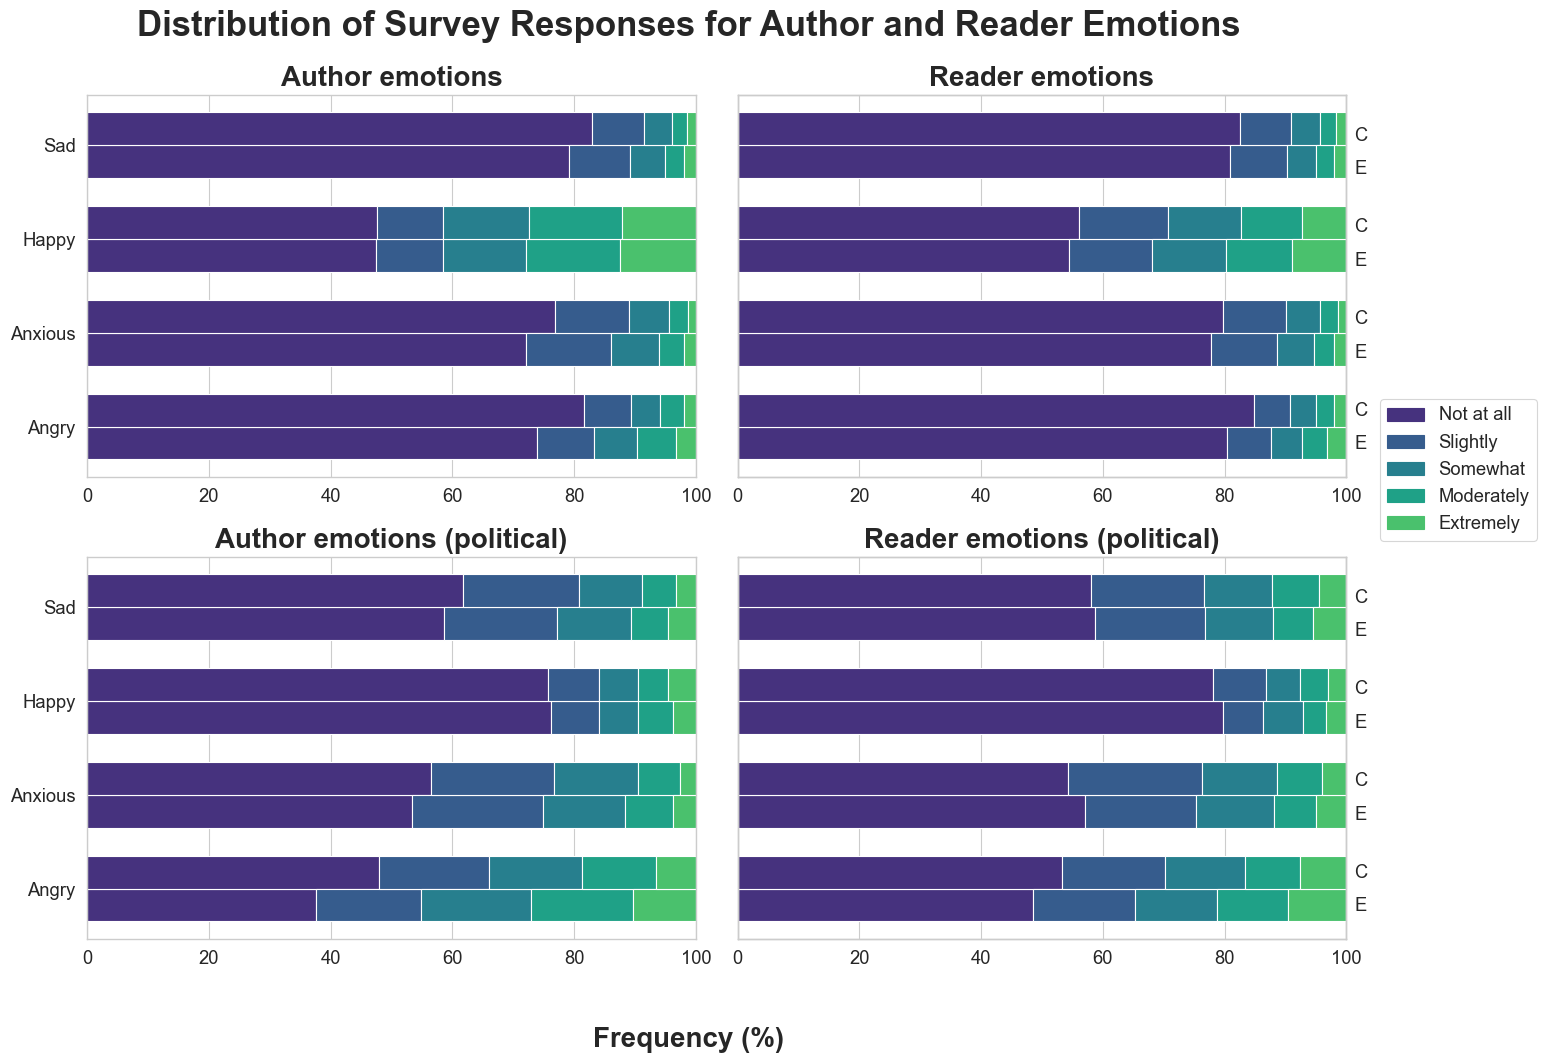

In [23]:
plot_author_reader_ems_likert(df)

## Political effects

In [24]:
def plot_pol_effects_likert(df: pd.DataFrame, 
                            title: str = 'Distribution of Survey Responses for Political Questions', 
                            users_type: str = 'all'): 
    """    
    Plots stacked bar charts for the response distribution of political effects across a 2x2 axis with plots for
    political leaning, in-group affect, out-group affect, and out-group animosity for just political tweets.
    
    Each subplot of stacked bar charts has a pair of bars corresponding to the Chronological and Engagement timelines.
    
    Params:
        df: DataFrame containing data of user survey responses, may consist of all users or just left-leaning or 
            right-leaning users
        title: title for entire grid of bar charts
        users_type: specifies set of users for table titles. can take on 'all', 'left', or 'right' corresponding to user's 
            political leaning
    """
    
    # specifies set of users in table titles
    assert users_type in ('all', 'left', 'right')
    
    fig = plt.figure(figsize=(20, 10))
    gs = gridspec.GridSpec(4, 4)  

    ax1 = plt.subplot(gs[0, 0:2])  
    ax2 = plt.subplot(gs[0, 2:4]) 
    ax3 = plt.subplot(gs[1, 0:2])  
    ax4 = plt.subplot(gs[1, 2:4]) 

    axes = [ax1, ax2, ax3, ax4]
    
    political_leaning_text = {
        -2: 'Far left',
        -1: 'Left',
        0: 'Moderate',
        1: 'Right',
        2: 'Far right'
    }
    
    group_effect_text = {
        -2: 'Much worse',
        -1: 'Worse',
        0: 'The same as before',
        1: 'Better',
        2: 'Much better'
    }
    
    outgroup_animosity_text = {
        0: 'No',
        1: 'Yes'
    }
    
    pol_df = df[df['is_political']]
    
    # plot subplots
    offset_palette(offset=2)
    create_likert_effects_subplot(pol_df, ['political_leaning'], axes[0], 'Political leaning', \
                                  political_leaning_text, table_titles=[f'Political leaning ({users_type} users)'])
    create_likert_effects_subplot(pol_df, ['ingroup_affect'], axes[2], 'In-group perception', \
                                  group_effect_text, table_titles=[f'In-group affect ({users_type} users)'])
    create_likert_effects_subplot(pol_df, ['outgroup_affect'], axes[3], 'Out-group perception', \
                                  group_effect_text, table_titles=[f'Out-group affect ({users_type} users)'], should_plot_tl=True)
    
    offset_palette(offset=0)
    create_likert_effects_subplot(pol_df, ['outgroup_animosity'], axes[1], 'Out-group animosity', \
                                  outgroup_animosity_text, table_titles=[f'Out-group animosity ({users_type} users)'], \
                                  should_plot_tl=True)
    
    # move all legends to the sides
    def adjust_legend(ax, legend_labels, loc, anchor_loc):
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), legend_labels, loc=loc, bbox_to_anchor=anchor_loc)
    
    adjust_legend(axes[0], list(political_leaning_text.values()), 'upper left', (-0.5, 1.05))
    adjust_legend(axes[1], list(outgroup_animosity_text.values()), 'upper right', (1.5, 1.05))
    adjust_legend(axes[2], list(group_effect_text.values()), 'upper left', (-0.5, 1.05))
    adjust_legend(axes[3], list(group_effect_text.values()), 'upper right', (1.5, 1.05))
    
    # add shared titles
    fig.suptitle(title, weight='bold', fontsize=25)
    fig.text(0.5, 0.35, 'Frequency (%)', ha='center', va='center', weight='bold', fontsize=20)
    
    plt.tight_layout(pad=1.0)
    plt.savefig(f"figures/likert/likert_pol_{users_type}.pdf", format="pdf", bbox_inches='tight')
    plt.show()

/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['user_id', 'timeline', key]).size().reset_index(name='count')
/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['user_id', 'timeline', key]).size().reset_index(name='count')
/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

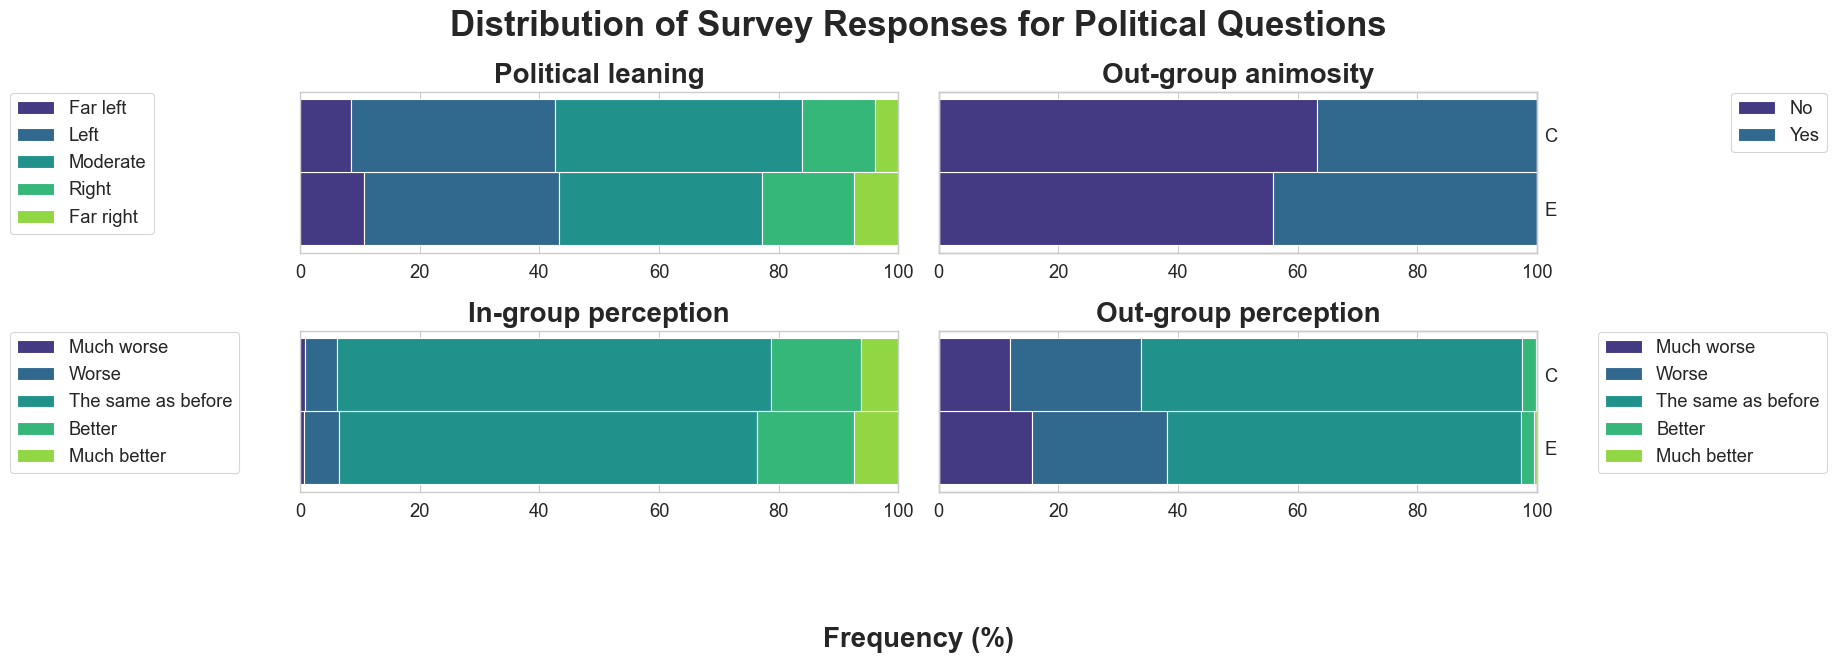

In [25]:
plot_pol_effects_likert(df)

/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['user_id', 'timeline', key]).size().reset_index(name='count')
/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['user_id', 'timeline', key]).size().reset_index(name='count')
/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

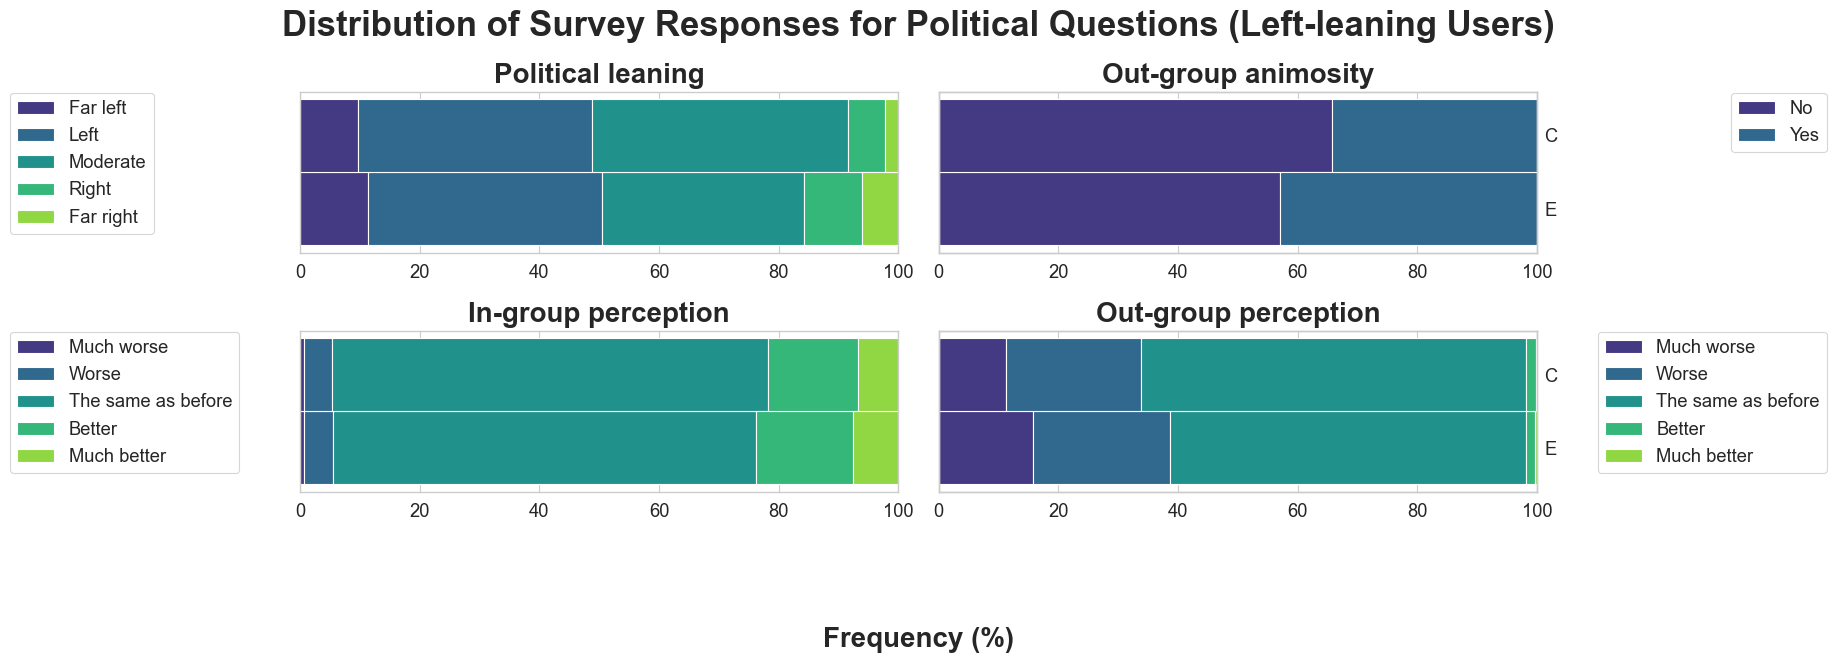

In [26]:
left_df = df[df['user_summary_leaning'] == LEFT]
plot_pol_effects_likert(left_df, 'Distribution of Survey Responses for Political Questions (Left-leaning Users)', \
                        'left')

/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['user_id', 'timeline', key]).size().reset_index(name='count')
/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['user_id', 'timeline', key]).size().reset_index(name='count')
/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

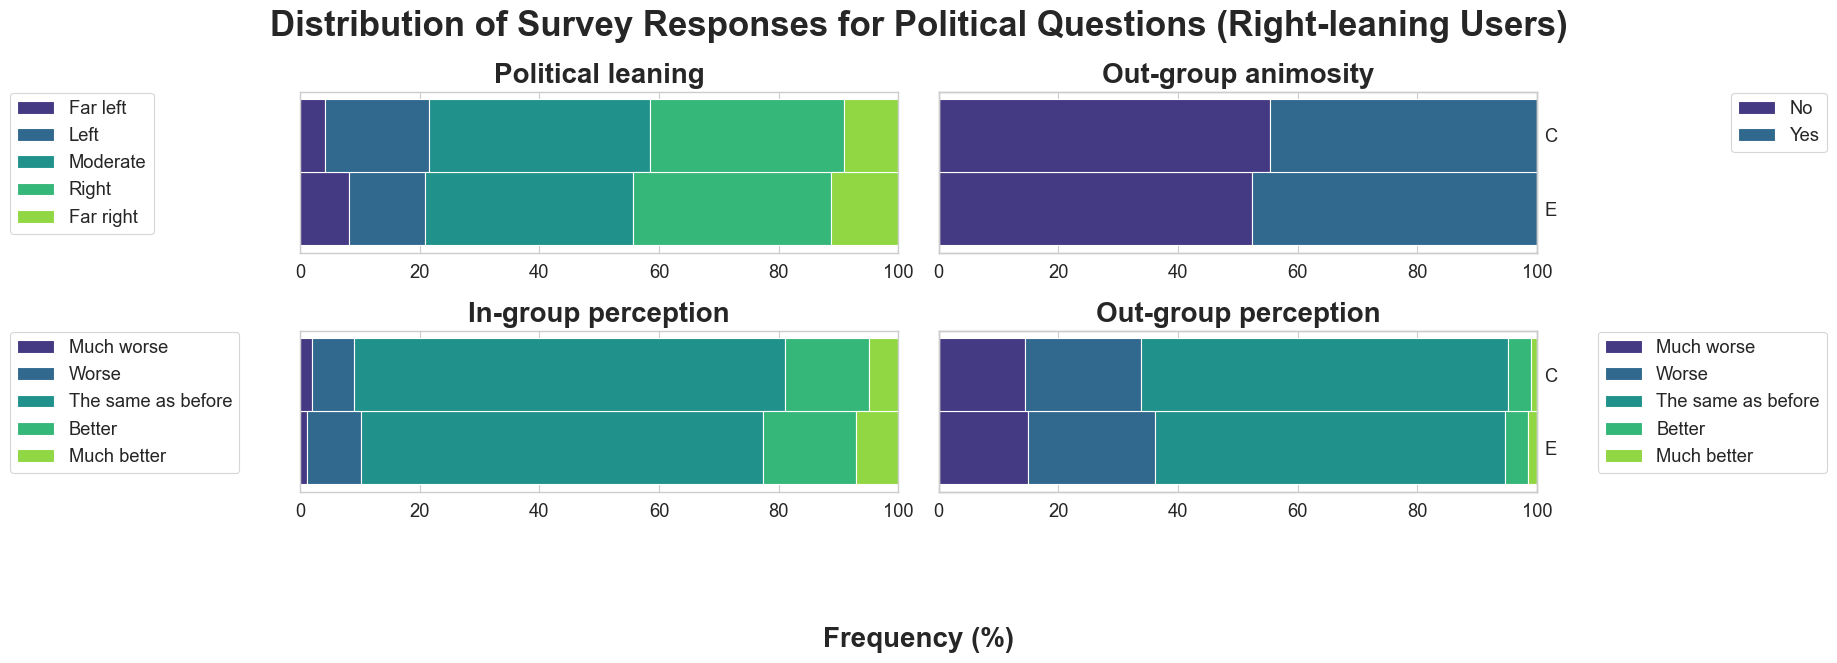

In [27]:
right_df = df[df['user_summary_leaning'] == RIGHT]
plot_pol_effects_likert(right_df, 'Distribution of Survey Responses for Political Questions (Right-leaning Users)', \
                        'right')

## Reader stated preference

In [28]:
def plot_explicit_pref_likert(df: pd.DataFrame):
    """    
    Plots stacked bar charts for the response distribution of political effects across a 1x2 axis with plots for
    explicit value (i.e. reader stated preference) across all tweets and just political tweets.
    
    Each subplot of stacked bar charts has a pair of bars corresponding to the Chronological and Engagement timelines.
    
    Params:
        df: DataFrame containing data of user survey responses, may be for all tweets or filtered down to political
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 3))
    
    explicit_val = {
        -1: 'No',
        0: 'Indifferent',
        1: 'Yes',
    }
    
    pol_df = df[df['is_political']]
    
    # plot subplots
    offset_palette(offset=1)
    create_likert_effects_subplot(df, ['value'], axes[0], 'Reader stated preference', \
                                  explicit_val, table_titles=['Reader stated preference'])
    create_likert_effects_subplot(pol_df, ['value'], axes[1], 'Reader stated preference (political)', \
                                  explicit_val, table_titles=['Reader stated preference (political)'], should_plot_tl=True)
    
    # add shared titles
    fig.suptitle('Distribution of Survey Responses for Reader Stated Preference', weight='bold', fontsize=25)
    fig.text(0.5, -0.1, 'Frequency (%)', ha='center', va='center', weight='bold', fontsize=20)
    
    legend_patches = [mpatches.Patch(color=sns.color_palette()[score], label=explicit_val[score]) for score in explicit_val]
    fig.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(1.05, 0.6))
    
    plt.tight_layout(pad=1.0)
    plt.savefig(f"figures/likert/likert_explicit_pref.pdf", format="pdf", bbox_inches='tight')
    plt.show()

/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['user_id', 'timeline', key]).size().reset_index(name='count')
/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = df.groupby(['user_id', 'timeline', key]).size().reset_index(name='count')
/Users/smitha/research/twitter-analysis/utils.py:462: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

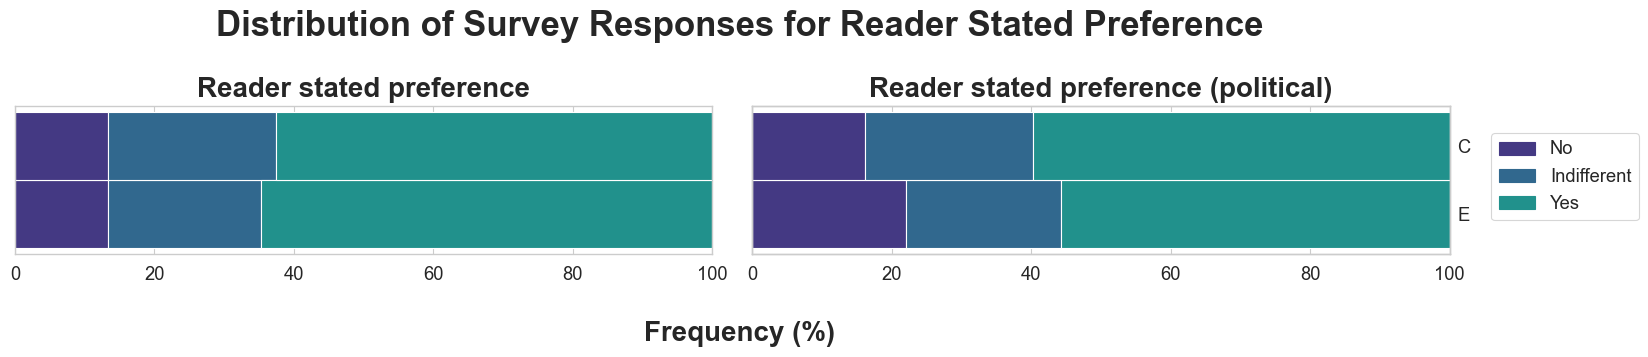

In [29]:
plot_explicit_pref_likert(df)